In [25]:
!pip install opencv-python

# Libraries

In [26]:
# Display
import matplotlib.pyplot as plt
# Directory
import cv2
import os
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

# Loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import losses, metrics

# Convert images to array of floats
import numpy as np

# GPU

In [27]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

device = "/GPU:0"

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Display

In [28]:
# Display
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow((images[i].astype(as_type) + 1) / 2, cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


# Load Images Dataset

In [29]:
train = np.loadtxt("text_data/cat_data.txt")
train = train.reshape((29843, 64, 64, 3))
train.shape

(29843, 64, 64, 3)

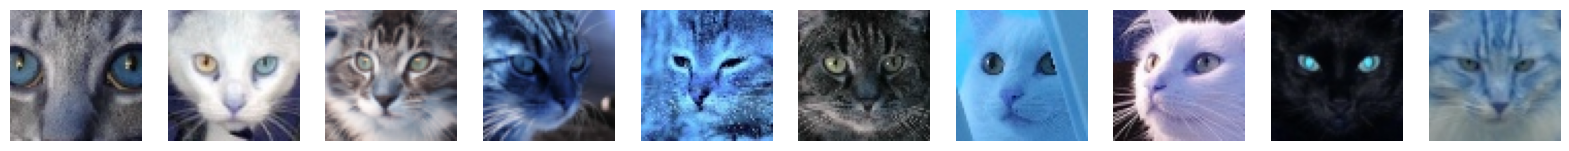

In [30]:
display(train[:10])

# Create Dataset

In [31]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(train[:29824])

In [32]:
dataset = dataset.shuffle(29825)

In [33]:
dataset = dataset.batch(batch_size)
# Prefetch done so I don't need to wait as long
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# GAN Start

In [34]:
# Variables
channels = 3
img_size = 64
img_shape = train[0].shape

noise_dim = 100

dropout = 0.1
relu_slope = 0.2
momentum = 0.85

epochs = 100
scale = 1

# Generator

In [35]:
class Generator(tf.keras.Model):
    def __init__(self, noise_dim, momentum):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.momentum = momentum

        # Define blocks (Currently using 5 major blocks)
        # Notes for self:
        #-When using leaky relu, 0.2 seems good for a GAN, since I am using negative 
        # input as well
        #-For batch normalization, numbers closer to 1 grab information from earlier 
        # back, which works well for stable data. I will use 0.85, since the cat picture
        # data is relatively stable.
        #-GANs for mnist (28, 28, 1) use 2-3 blocks, so I will use 5 blocks for my
        # larger images (64, 64, 3)
        #-Kernel of 4 since I want a lot of information, but I also want good effeciency


        self.reshape = layers.Reshape((1, 1, 100))
        self.conv2d_1 = layers.Conv2DTranspose(1024, kernel_size=4, strides=1, padding="valid", use_bias = False)
        self.batch_norm1 = layers.BatchNormalization(momentum=self.momentum)
        self.relu1 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_2 = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm2 = layers.BatchNormalization(momentum=self.momentum)
        self.relu2 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_3 = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm3 = layers.BatchNormalization(momentum=self.momentum)
        self.relu3 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_4 = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm4 = layers.BatchNormalization(momentum=self.momentum)
        self.relu4 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_5 = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias = False)
        self.batch_norm5 = layers.BatchNormalization(momentum=self.momentum)
        self.relu5 = layers.LeakyReLU(alpha=relu_slope) 

        self.conv2d_final = layers.Conv2DTranspose(3, kernel_size=4, strides=1, padding="same", activation="tanh", use_bias=False)

    def call(self, noise):
        x = self.reshape(noise)
        x = self.conv2d_1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)

        x = self.conv2d_2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)

        x = self.conv2d_3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)

        x = self.conv2d_4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)

        x = self.conv2d_5(x)
        x = self.batch_norm5(x)
        x = self.relu5(x)

        imgs = self.conv2d_final(x)

        return imgs
    
    def generate(self, batch_size, noise):
        if noise is None:
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        return self.call(tf.convert_to_tensor(noise, tf.float32))
    

In [36]:
# Quick check
generator = Generator(noise_dim, momentum=momentum)
images = generator.generate(batch_size, None)

(64, 64, 64, 3)


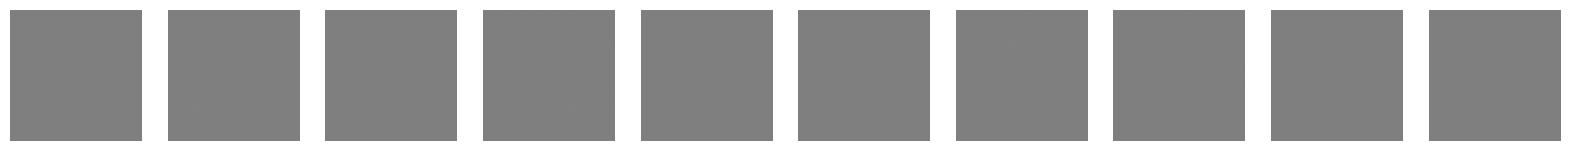

In [37]:
print(images.shape)
display(images.numpy()[:10])
# Yep that's noise

In [38]:
input_shape = (batch_size, noise_dim)
generator.build(input_shape)
generator.summary()

Model: "generator_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (64, 1, 1, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (64, 4, 4, 1024)       │     1,638,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (64, 4, 4, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (64, 8, 8, 512)        │     8,388,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (64, 8, 8, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (64, 16, 16, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (64, 16, 16, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (64, 32, 32, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (64, 32, 32, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (64, 64, 64, 64)       │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (64, 64, 64, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (64, 64, 64, 3)        │         3,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,790,528 (48.79 MB)

 Trainable params: 12,786,560 (48.78 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Discriminator

In [39]:
class Discriminator(tf.keras.Model):
    def __init__(self, dropout):
        super(Discriminator, self).__init__()

        self.conv2d_1 = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)
        # no batch norm because first layer
        self.relu1 = layers.LeakyReLU(alpha = relu_slope)
        self.dropout1 = layers.Dropout(dropout)

        self.conv2d_2 = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)
        self.batch_norm2 = layers.BatchNormalization(momentum=momentum)
        self.relu2 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout2 = layers.Dropout(dropout)

        self.conv2d_3 = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)
        self.batch_norm3 = layers.BatchNormalization(momentum=momentum)
        self.relu3 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout3 = layers.Dropout(dropout)

        self.conv2d_4 = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)
        self.batch_norm4 = layers.BatchNormalization(momentum=momentum)        
        self.relu4 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout4 = layers.Dropout(dropout)

        self.conv2d_5 = layers.Conv2D(1024, kernel_size=4, strides=1, padding="same", use_bias=False)
        self.batch_norm5 = layers.BatchNormalization(momentum=momentum)        
        self.relu5 = layers.LeakyReLU(alpha = relu_slope) 
        self.dropout5 = layers.Dropout(dropout)

        self.conv2d_final = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias = False, activation = 'sigmoid')

        self.flatten = layers.Flatten()


 
    def call(self, inputs, training=False):
        x = self.conv2d_1(inputs)
        x = self.relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2d_2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x, training=training)

        x = self.conv2d_3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x, training=training)

        x = self.conv2d_4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        x = self.dropout4(x, training=training)

        #x = self.conv2d_5(x)
        #x = self.batch_norm5(x)
        #x = self.relu5(x)
        #x = self.dropout5(x, training=training)

        x = self.conv2d_final(x)

        x = self.flatten(x)
        
        return x

In [40]:
# Quick check
discriminator = Discriminator(dropout)
print(images[10].shape)
print(discriminator(images[:10]))


(64, 64, 3)


/home/dsu/Desktop/Projects/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'discriminator_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


tf.Tensor(
[[0.4999746 ]
 [0.5000039 ]
 [0.49997962]
 [0.500008  ]
 [0.5000148 ]
 [0.49999976]
 [0.50003016]
 [0.5000135 ]
 [0.5000398 ]
 [0.5000138 ]], shape=(10, 1), dtype=float32)


In [41]:
discriminator.summary()

Model: "discriminator_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (10, 32, 32, 64)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (10, 16, 16, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (10, 16, 16, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (10, 8, 8, 256)        │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (10, 8, 8, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (10, 4, 4, 512)        │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (10, 4, 4, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (10, 1, 1, 1)          │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (10, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,360 (10.56 MB)

 Trainable params: 2,765,568 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Build actual GAN

In [42]:
class CatGAN(models.Model):
    def __init__(self, discriminator, generator, noise_dim):
        super(CatGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim

    def compile(self, dis_optimizer, gen_optimizer):
        super(CatGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.dis_optimizer = dis_optimizer
        self.gen_optimizer = gen_optimizer
        self.dis_loss_metric = metrics.Mean(name="dis_loss")
        self.gen_loss_metric = metrics.Mean(name="gen_loss")

    @property
    def metrics(self):
        return [self.dis_loss_metric, self.gen_loss_metric]

    def train_step(self, real_images):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            # fake images
            fake_images = self.generator.generate(batch_size, None)
            # do predictions
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(fake_images, training = True)

            # label data
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(tf.shape(fake_predictions))

            # calculate loss
            dis_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            dis_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            dis_loss = (dis_real_loss + dis_fake_loss) / 2.0

            gen_loss = self.loss_fn(real_labels, fake_predictions)

        grad_dis = dis_tape.gradient(dis_loss, self.discriminator.trainable_variables)
        grad_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)

        self.dis_optimizer.apply_gradients(zip(grad_dis, discriminator.trainable_variables)) 
        self.gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

        self.dis_loss_metric.update_state(dis_loss)
        self.gen_loss_metric.update_state(gen_loss)

        return {m.name: m.result() for m in self.metrics}

catGAN = CatGAN(discriminator=discriminator, generator=generator, noise_dim=noise_dim)


catGAN.compile(
    dis_optimizer=Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
    gen_optimizer=Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
)

inp_shape = (batch_size, img_shape, img_shape, channels)
catGAN.build(inp_shape)
catGAN.summary()

Model: "cat_gan_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_1 (Discriminator) │ ?                      │     2,767,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_1 (Generator)         │ ?                      │    12,790,528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,557,888 (59.35 MB)

 Trainable params: 15,552,128 (59.33 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [43]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import math

n_batches = math.ceil(29843/batch_size)

checkpoint_cb = ModelCheckpoint(
    "checkpointGAN/model_checkpoint.weights.h5",
    #"checkpointGAN/model_checkpoint_{epoch:02d}.weights.h5", # <--- this broke everything
    save_weights_only=True,
    save_best_only = False,
    verbose=1,
    save_freq=10*n_batches
)

class ModelMonitor(Callback):
    def __init__(self, catGAN):
        self.catGAN = catGAN

    def on_epoch_end(self, epoch, logs=None):
        # update scale
        #self.catGAN.scale = 1 - (epoch / epochs)
        # generate image
        if epoch % 1 == 0:
            gen_imgs = self.catGAN.generator.generate(batch_size, None)
            img = ((gen_imgs[0] + 1) / 2) * 255
            img = img.numpy()
            img = array_to_img(img)
            img.save(os.path.join("text_data", "img_" + str(epoch / 10) + ".png"))
        


In [44]:
hist = catGAN.fit(dataset, epochs=epochs, callbacks=[ModelMonitor(catGAN), checkpoint_cb])

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 63s 36ms/step - dis_loss: 0.3887 - gen_loss: 2.8659
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - dis_loss: 0.4074 - gen_loss: 2.0908
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - dis_loss: 0.4866 - gen_loss: 1.7272
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - dis_loss: 0.5653 - gen_loss: 1.3795
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - dis_loss: 0.5570 - gen_loss: 1.2588
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - dis_loss: 0.6360 - gen_loss: 1.0608
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - dis_loss: 0.6797 - gen_loss: 0.9111
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - dis_loss: 0.6892 - gen_loss: 0.8466
Epoch 9/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - dis_loss: 0.6817 - gen_loss: 0.8350
Epoch 10/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - dis_loss: 0.6904 - gen_loss: 0.8094
Epoch 11/100
  8/466 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - dis_loss: 0

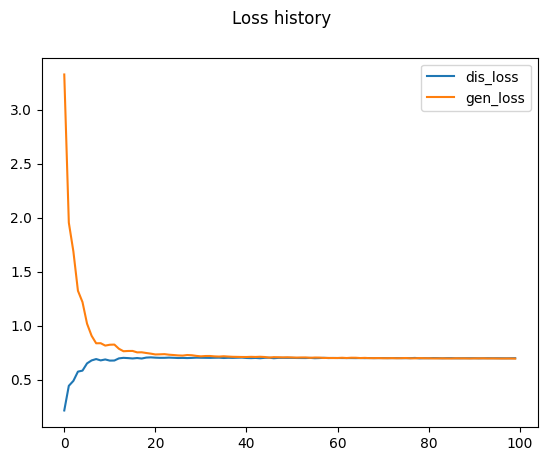

In [45]:
plt.suptitle("Loss history")
plt.plot(hist.history["dis_loss"], label="dis_loss")
plt.plot(hist.history["gen_loss"], label="gen_loss")
plt.legend()
plt.show()

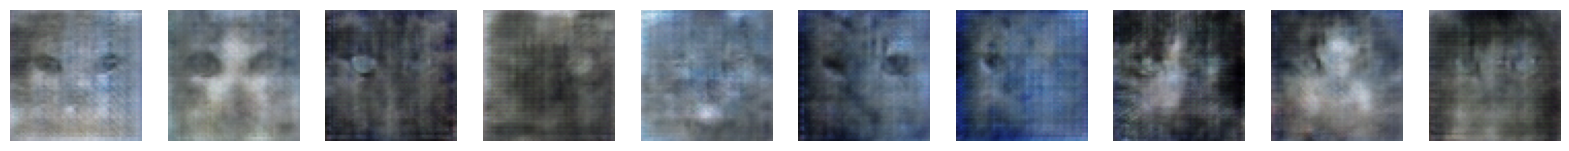

In [46]:
imgs = catGAN.generator.generate(batch_size, None)
display(imgs.numpy()[:10])

In [47]:
recon = CatGAN(generator, discriminator, noise_dim)
recon.load_weights('checkpoint/model_checkpoint_30.weights.h5')

ValueError: You are loading weights into a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.

: 

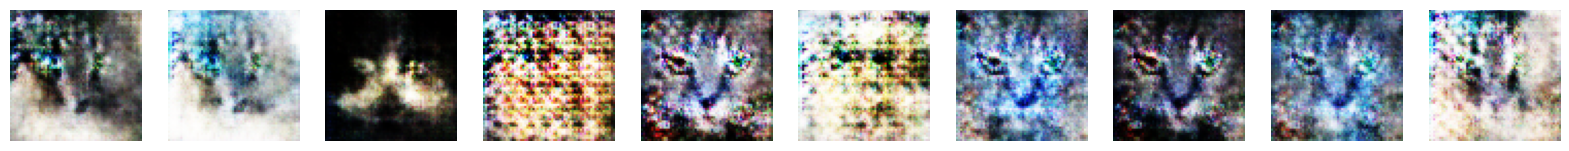

In [30]:
batch = recon.generator.generate(batch_size, None)
display(batch.numpy()[:10])